In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(py['main'])
import Trade
from DataBase_wheels import small_updates
os.chdir(curr)
data_folder = os.getcwd()+'\\Data\\IO'
gams_folder = os.getcwd()+'\\gamsmodels\\Trade'

The file_gams_py_gdb0.gdx is still active and was not deleted.
The file_gams_py_gdb1.gdx is still active and was not deleted.
The file_gams_py_gdb3.gdx is still active and was not deleted.


The trade model can be specified in various ways. In this simple module, the trade modules simply specifies the foreign demand for domestically produced goods in an Armington-like manner. As there are more than one foreign/domestic goods, the prices entering the demand function are the domestic price relative to the foreign price of a similar good; this similarity is declared in a mapping denoted *dom2for[n,nn]* coupling domestic goods to a foreign counterpart.

### *1: Read in data*

*Load IO data:*

In [2]:
GE_data = DataBase.GPM_database(pickle_path=data_folder+'\\GE_data')

*Load global settings:*

In [3]:
with open(data_folder+'\\Ex1_gs',"rb") as file:
    gs = pickle.load(file)

*Define settings for the module:*

In [4]:
name_module = 'trade'
data = {'file': 'trade.xlsx', 'sheets': {'vars': 'vars', 'dom2for': 'maps'}} # read in the sheet 'vars' as variables, and 'dom2for' as mappings.}
kwargs_st = {'sector': True, 'ss': GE_data.get('s_for')} # settings for initializing the module

*load data:*

In [5]:
db = excel2py.xl2PM.pm_from_workbook(data_folder+'\\'+data['file'],data['sheets'])

### *2: Initialize and run model*

*initialize model:*

In [7]:
gm_trade = Trade.trade_dynamic(work_folder=work_folder,kwargs_st=kwargs_st,gs_v=gs,**{'data_folder':gams_folder,'name':name_module})

*subset GE data to relevant sectors:*

In [8]:
GE_trade = small_updates.subset_db(GE_data.copy(),GE_data.get('s_for'))

*initialize relevant subsets from GE data, and add data loaded from excel sheets:*

In [9]:
gm_trade.add_sets_from_GE(GE_trade)
DataBase.GPM_database.merge_dbs(gm_trade.model.database,db,'second')

*initialize variables from GE data:*

In [10]:
gm_trade.ivfs(GE_trade,merge=False) # initialize levels from static model

*set to calibration mode and solve:*

In [11]:
GE_trade_t = DataBase.GPM_database()
for var in GE_trade.variables_flat:
    GE_trade_t[var] = DataBase_wheels.repeat_variable_windex(GE_trade.get(var),gm_trade.get('t0'))
gm_trade.setstate('DC')
GE_trade_t = gm_trade.slice_exo(GE_trade_t,copy=False)
gm_trade.calibrate_sneaky(GE_trade_t,overwrite=True,**{'n_steps':2,'diff':True})

{'Modelstat': 15.0, 'Solvestat': 1.0}

*Export as pickle:*

In [12]:
db = gm_trade.model_instances['baseline'].out_db 
[db.series.__delitem__(sym) for sym in db.symbols if sym not in gm_trade.model.database.symbols];
gm_trade.model.database.merge_dbs(gm_trade.model.database,db,'second')
gm_trade.export()

'C:\\Users\\sxj477\\Documents\\GitHub\\GPM_v05\\examples\\gamsmodels\\Trade\\gmspython_trade'

*Inspect solution compared to IO data:*

{'maxdiff': 0.0, 'plotdiff': None}


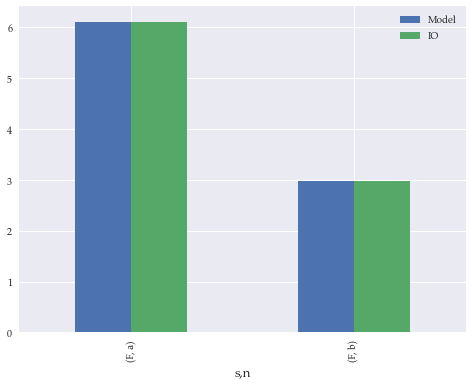

In [13]:
var,year,kwargs = 'qD',2, {'level':'t'}
print(diagnostics.compare_data.std_diagnostics_var(db,GE_data,var,xs=year,plot=False,**kwargs))
pd.DataFrame({'Model': diagnostics.compare_data.get_db1(db,GE_data,var,xs=year,**kwargs), 'IO': diagnostics.compare_data.get_db2(db,GE_data,var,xs=year,**kwargs)}).plot.bar(figsize=(8,6));